In [20]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# mean, std = 0.1307, 0.3081

# train_dataset = MNIST('../data/MNIST', train=True, download=True,
#                              transform=transforms.Compose([
#                                  transforms.ToTensor(),
#                                  transforms.Normalize((mean,), (std,))
#                              ]))
# test_dataset = MNIST('../data/MNIST', train=False, download=True,
#                             transform=transforms.Compose([
#                                 transforms.ToTensor(),
#                                 transforms.Normalize((mean,), (std,))
#                             ]))
# n_classes = 10

'''
Resizing MNIST for Resnet18 to 224
'''
mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.Grayscale(num_output_channels=3),
                                 transforms.Resize(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.Grayscale(num_output_channels=3),
                                transforms.Resize(224),
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [22]:
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [23]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Siamese network

$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$


In [27]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingResNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingResNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 5
log_interval = 100

In [28]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.117180
Train: [400/60000 (1%)]	Loss: 0.170388
Train: [800/60000 (1%)]	Loss: 0.170665
Train: [1200/60000 (2%)]	Loss: 0.128018
Train: [1600/60000 (3%)]	Loss: 0.124466
Train: [2000/60000 (3%)]	Loss: 0.119752
Train: [2400/60000 (4%)]	Loss: 0.104446
Train: [2800/60000 (5%)]	Loss: 0.102521
Train: [3200/60000 (5%)]	Loss: 0.107576
Train: [3600/60000 (6%)]	Loss: 0.111234
Train: [4000/60000 (7%)]	Loss: 0.103640
Train: [4400/60000 (7%)]	Loss: 0.090784
Train: [4800/60000 (8%)]	Loss: 0.113709
Train: [5200/60000 (9%)]	Loss: 0.101589
Train: [5600/60000 (9%)]	Loss: 0.105871
Train: [6000/60000 (10%)]	Loss: 0.078029
Train: [6400/60000 (11%)]	Loss: 0.095279
Train: [6800/60000 (11%)]	Loss: 0.080651
Train: [7200/60000 (12%)]	Loss: 0.089593
Train: [7600/60000 (13%)]	Loss: 0.079904
Train: [8000/60000 (13%)]	Loss: 0.087305
Train: [8400/60000 (14%)]	Loss: 0.095584
Train: [8800/60000 (15%)]	Loss: 0.073396
Train: [9200/60000 (15%)]	Loss: 0.083911
Train: [9600/60000 (16%)]	Loss: 0.07

KeyboardInterrupt: 

In [29]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

KeyboardInterrupt: 

# Triplet network

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] 

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [34]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 4
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingResNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingResNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 3.43 GiB already allocated; 0 bytes free; 3.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

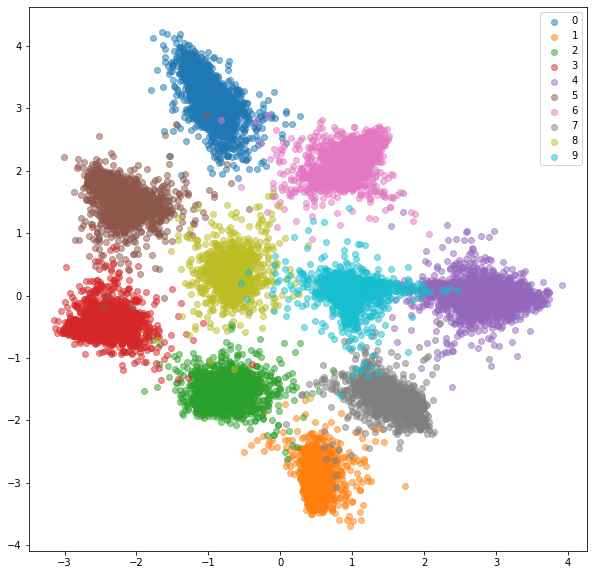

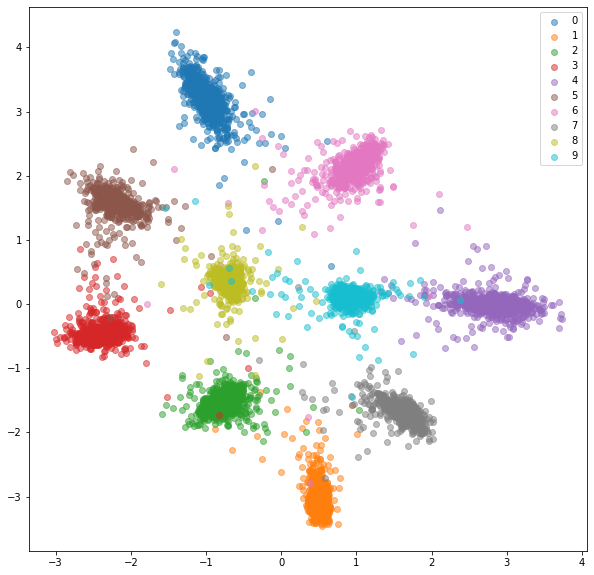

In [18]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)